
[INFO] Memproses gdp_per_capita tahun 2000.png...
  -> ⚠️ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> ✅ Sukses: Data diekstrak.

[INFO] Memproses gdp_per_capita tahun 2001.png...
  -> ⚠️ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> ✅ Sukses: Data diekstrak.

[INFO] Memproses gdp_per_capita tahun 2002.png...
  -> ⚠️ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.
  -> ✅ Sukses: Data diekstrak.

[INFO] Memproses gdp_per_capita tahun 2003.png...
  -> ⚠️ Peringatan Kalibrasi: tesseract is not installed or it's not in your PATH. See README file for more information.
  -> ⚠️ Peringatan: Kali

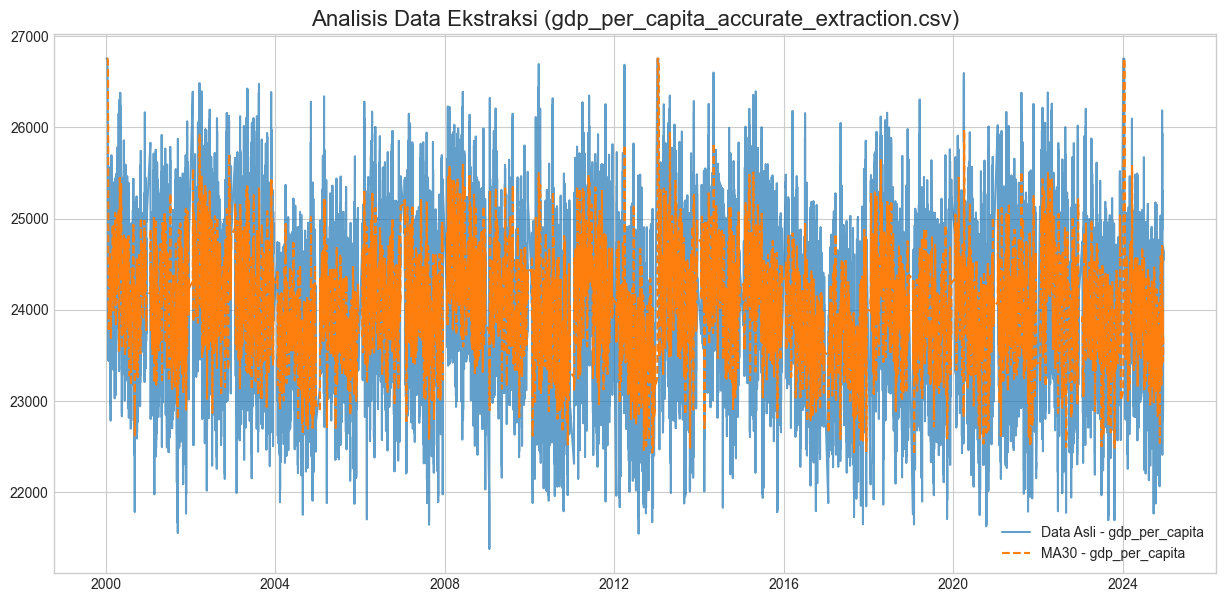


✅ SUKSES! 84983 baris data disimpan ke gdp_per_capita_accurate_extraction.csv


In [2]:
# ==============================================================================
# Script Ekstraksi Data Grafik v4.1 (Fleksibel Multi/Single Variabel)
# Deskripsi:
#   Versi ini secara fleksibel menangani satu atau banyak variabel dengan
#   tetap menggunakan deteksi plot otomatis dan kalibrasi sumbu Y.
#
# Kebutuhan: opencv-python, numpy, pandas, pytesseract, matplotlib
# ==============================================================================

import cv2
import numpy as np
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import pytesseract
from typing import List, Dict, Tuple, Optional, Any
from datetime import datetime, timedelta

# (Letakkan blok CONFIG dari atas di sini)
CONFIG = {
    "folder_path": r"C:\Users\LENOVO\Downloads\statexplore\Data\C02\gdp_per_capita",
    "output_csv_file": "gdp_per_capita_accurate_extraction.csv",
    "fallback_y_min": 21000,
    "fallback_y_max": 27000,
    "clamp_y_min": 20000,
    "clamp_y_max": 40000,
    "var_name": "gdp_per_capita",
    "lower_color": np.array([90, 80, 50]),
    "upper_color": np.array([130, 255, 255]),
    "visualize_output": True
}

# ==============================================================================
# 2. FUNGSI-FUNGSI BANTU & PREPROCESSING
# ==============================================================================
def is_leap(year: int) -> bool: return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)
def clean_mask(mask: np.ndarray) -> np.ndarray:
    kernel = np.ones((3, 3), np.uint8)
    return cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

# ==============================================================================
# 3. FUNGSI DETEKSI & KALIBRASI OTOMATIS
# ==============================================================================
def find_plot_area(image: np.ndarray) -> Optional[Tuple[np.ndarray, Dict[str, int]]]:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    if w > image.shape[1] * 0.5 and h > image.shape[0] * 0.5:
        return image[y:y+h, x:x+w], {'x': x, 'y': y, 'w': w, 'h': h}
    return None

def calibrate_yaxis(image: np.ndarray, plot_coords: Dict[str, int]) -> Optional[Dict[str, float]]:
    try:
        yaxis_crop = image[plot_coords['y']:plot_coords['y']+plot_coords['h'], 0:plot_coords['x']]
        gray_yaxis = cv2.cvtColor(yaxis_crop, cv2.COLOR_BGR2GRAY)
        ocr_text = pytesseract.image_to_string(gray_yaxis, config='--psm 6 -c tessedit_char_whitelist=0123456789')
        ocr_numbers = sorted([int(n) for n in re.findall(r'\b\d+\b', ocr_text)], reverse=True)
        if len(ocr_numbers) < 2: return None

        plot_gray = cv2.cvtColor(image[plot_coords['y']:plot_coords['y']+plot_coords['h'], plot_coords['x']:plot_coords['x']+plot_coords['w']], cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(plot_gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=plot_coords['w']*0.8, maxLineGap=10)
        if lines is None: return None

        grid_y_coords = sorted(list(set([line[0][1] for line in lines])))
        if len(grid_y_coords) >= 2 and len(ocr_numbers) >= 2:
            top_line_y, bottom_line_y = grid_y_coords[0], grid_y_coords[-1]
            top_val, bottom_val = ocr_numbers[0], ocr_numbers[-1]
            pixel_span = bottom_line_y - top_line_y
            value_span = top_val - bottom_val
            if pixel_span == 0 or value_span == 0: return None
            pixels_per_value = pixel_span / value_span
            calibrated_y_max = top_val + (top_line_y / pixels_per_value)
            calibrated_y_min = calibrated_y_max - (plot_coords['h'] / pixels_per_value)
            print(f"  -> ✅ Kalibrasi Sumbu Y berhasil: Min={calibrated_y_min:.0f}, Max={calibrated_y_max:.0f}")
            return {'min': calibrated_y_min, 'max': calibrated_y_max}
    except Exception as e:
        print(f"  -> ⚠️ Peringatan Kalibrasi: {e}")
    return None

# ==============================================================================
# 4. FUNGSI EKSTRAKSI & PEMROSESAN
# ==============================================================================
def extract_series_from_mask(mask: np.ndarray, params: Dict[str, Any]) -> pd.DataFrame:
    extracted_data = []
    plot_h, plot_w = mask.shape
    days_in_year = 366 if is_leap(params['year']) else 365
    start_date = datetime(params['year'], 1, 1)
    for x_pixel in range(plot_w):
        y_pixels = np.where(mask[:, x_pixel] > 0)[0]
        if len(y_pixels) > 0:
            y_pixel_center = int(np.median(y_pixels))
            value = params['y_max'] - ((y_pixel_center / plot_h) * (params['y_max'] - params['y_min']))
            value = max(min(value, params['clamp_y_max']), params['clamp_y_min'])
            day_of_year = int((x_pixel / plot_w) * days_in_year)
            date = start_date + timedelta(days=day_of_year)
            extracted_data.append({
                "Date": date.strftime("%Y-%m-%d"), "Year": params['year'],
                "DayOfYear": day_of_year + 1, 
                params['var_name']: int(round(value, 0)) 
            })
    return pd.DataFrame(extracted_data)
    
def post_process_data(df: pd.DataFrame, config: Dict[str, Any]) -> pd.DataFrame:
    proc_df = df.copy(); proc_df['Date'] = pd.to_datetime(proc_df['Date']); proc_df = proc_df.sort_values(by='Date').set_index('Date').drop(columns=['Year', 'DayOfYear']); proc_df.interpolate(method='time', inplace=True); proc_df.dropna(inplace=True);
    vars_to_analyze = [v['name'] for v in config.get('variables', [])] or [config.get('var_name')]
    for var_name in vars_to_analyze:
        if var_name in proc_df.columns: proc_df[f'{var_name}_MA30'] = proc_df[var_name].rolling(window=30).mean()
    return proc_df

def visualize_results(df: pd.DataFrame, config: Dict[str, Any]):
    title = f"Analisis Data Ekstraksi ({config['output_csv_file']})"; plt.style.use('seaborn-v0_8-whitegrid'); fig, ax = plt.subplots(figsize=(15, 7));
    vars_to_plot = [v['name'] for v in config.get('variables', [])] or [config.get('var_name')]
    for var_name in vars_to_plot:
        if var_name in df.columns: ax.plot(df.index, df[var_name], label=f'Data Asli - {var_name}', alpha=0.7); ax.plot(df.index, df[f'{var_name}_MA30'], label=f'MA30 - {var_name}', linestyle='--')
    ax.set_title(title, fontsize=16); ax.legend(); plt.show()

# ==============================================================================
# 5. FUNGSI UTAMA (Runner)
# ==============================================================================
def main(config: Dict[str, Any]):
    if not os.path.isdir(config['folder_path']):
        print(f"❌ KESALAHAN: Folder tidak ditemukan di '{config['folder_path']}'.")
        return

    all_files = sorted([f for f in os.listdir(config['folder_path']) if f.endswith(".png")])
    all_results = []
    
    for filename in all_files:
        print(f"\n[INFO] Memproses {filename}...")
        full_path = os.path.join(config['folder_path'], filename)
        img = cv2.imread(full_path)
        if img is None: continue

        plot_info = find_plot_area(img)
        if not plot_info:
            print("  -> ⚠️ Peringatan: Area plot tidak terdeteksi, file dilewati.")
            continue
        plot_area, plot_coords = plot_info
        
        calibration = calibrate_yaxis(img, plot_coords)
        if calibration:
            y_min, y_max = calibration['min'], calibration['max']
        else:
            print("  -> ⚠️ Peringatan: Kalibrasi gagal, menggunakan nilai fallback.")
            y_min, y_max = config['fallback_y_min'], config['fallback_y_max']

        year_from_file = int(re.search(r'(\d{4})', filename).group(1))
        hsv = cv2.cvtColor(plot_area, cv2.COLOR_BGR2HSV)
        
        variables_to_process = config.get('variables', [{"name": config.get('var_name'), "lower_color": config.get('lower_color'), "upper_color": config.get('upper_color')}])
        
        year_dataframes = []
        for var_info in variables_to_process:
            mask = cv2.inRange(hsv, var_info['lower_color'], var_info['upper_color'])
            series_params = {
                'year': year_from_file, 'y_min': y_min, 'y_max': y_max,
                'clamp_y_min': config['clamp_y_min'], 'clamp_y_max': config['clamp_y_max'],
                'var_name': var_info['name']
            }
            df_year_var = extract_series_from_mask(mask, series_params)
            if not df_year_var.empty:
                year_dataframes.append(df_year_var)
        
        if year_dataframes:
            all_results.append(year_dataframes[0])
            print(f"  -> ✅ Sukses: Data diekstrak.")

    if not all_results: print("\n⚠️ PROSES SELESAI: Tidak ada data yang berhasil diekstrak."); return
    
    raw_df = pd.concat(all_results, ignore_index=True)
    analyzed_df = post_process_data(raw_df, config)
    if config.get('visualize_output', True): visualize_results(analyzed_df, config)
    
    analyzed_df.reset_index(inplace=True)
    analyzed_df.to_csv(config['output_csv_file'], index=False)
    print(f"\n✅ SUKSES! {len(analyzed_df)} baris data disimpan ke {config['output_csv_file']}")

if __name__ == '__main__':
    main(CONFIG)